# ECU Floods

Notebook to compare flash flood risk in Ecuador

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt
import shapely

In [2]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [3]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

In [4]:
def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

## Flood risk All

In [5]:
# Git tif files
rst_fns = glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_Ecuador.tif')
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_Ecuador.tif']

In [6]:
# Open flood susceptability layer
ecu_fn = DATA_PATH+'raw/ECU-Floods/Susceptibility/FF_suscept_PCA.shp'
col = 'susc_PCA'
ecu_all = poly_prep(ecu_fn, col)

In [7]:
# Need to reproject crs to epsg:4326
ecu_all = ecu_all.to_crs('epsg:4326')


In [8]:
# Run zonal stats loop
ecu_all_sum = zone_loop(ecu_all, rst_fns, 'sum', col, '_all_Ecuador.tif')

Started GPWv4
Started ESRI16
Started LS15
Started WP16
Started GHS15


In [9]:
# fill nan with 0
ecu_all_sum = ecu_all_sum.fillna(0)

In [16]:
ecu_all_sum.iloc[:,2:7]

,GPWv4_sum,ESRI16_sum,LS15_sum,WP16_sum,GHS15_sum
0,586.389954,311.0,4086.0,1924.792725,1417.930309
1,8320.468750,7018.0,12093.0,10621.904297,11145.986740
2,8525.533203,11395.0,8761.0,14601.945312,965.884866
3,18385.765625,12786.0,21518.0,16893.302734,30857.327373
4,2577.183105,3230.0,972.0,1834.959473,1364.476154
...,...,...,...,...,...
1898,0.000000,0.0,113.0,124.480164,0.000000
1899,16165.535156,6636.0,8329.0,9902.400391,18568.724618
1900,0.000000,0.0,142.0,0.000000,0.000000
1901,3163.505859,762.0,464.0,2650.011963,311.943406


# SOMET

In [17]:
# Find range
ecu_all_sum['max'] = ecu_all_sum.iloc[:,2:7].values.max(1)
ecu_all_sum['min'] = ecu_all_sum.iloc[:,2:7].values.min(1)
ecu_all_sum['dif'] = ecu_all_sum['max'] - ecu_all_sum['min']

In [21]:
# ask some questions 
print('What is the max difference?', max(ecu_all_sum['dif']))
ecu_all_sum[ecu_all_sum['dif'] > 924668]

What is the max difference? 924668.359375


,geometry,susc_PCA,GPWv4_sum,ESRI16_sum,LS15_sum,WP16_sum,GHS15_sum,max,min,dif
146,"POLYGON ((-79.97083 -2.11250, -79.96866 -2.111...",0.400676,94597.640625,1019266.0,690659.0,718726.5,788709.005187,1019266.0,94597.640625,924668.359375


/Users/cascade/opt/miniconda3/envs/geo38/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cascade/opt/miniconda3/envs/geo38/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


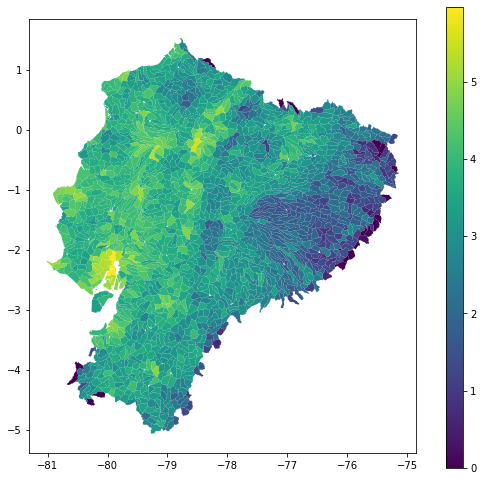

In [19]:
# Sorted scatter plot

# Data
col = 'dif'
data = ecu_all_sum[['geometry', col]]
data['log'] = np.where(data[col] != 0, np.log10(data[col]), 0)

# plot
fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

data.plot(column = 'log', ax = axs);

# color bar 
vmin, vmax = 0, max(data['log'])
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cax)

In [ ]:
# Ask some questions
print('What is the max dif:', max(ecu_all_sum['dif']), '\n')
ecu_all_sum[ecu_all_sum['dif'] == 1057006.75]